In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *

import pickle

from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri
from matplotlib.lines import Line2D
import random
random.seed(10)

In [2]:
# get probability of all single mutations for a given sequence and w/b.
def prob_mut(seq, i1i2, w, b):
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = 20-2)(delayed(col_H)                                                   
        (i0, i1i2, w, b, seq)
        for i0 in range(len(seq))) 
    H_array = resH


    count = 0
    prob_tot = 0.
    max_prob = 0.
    max_id = -1
    for i0 in range(n_var):
        i1,i2 = i1i2[i0][0], i1i2[i0][1]

        #We dont need to go section/position by section/position but this is more explicit
        for ii,i in enumerate(range(i1,i2)):
            H_i = H_array[i]
            temp_sequence = np.copy(seq)
            sig_section = np.zeros(i2-i1)
            
            sig_section[ii] = 1.
            temp_sequence[i1:i2] = sig_section
            count+=1
            
            mut_probs = np.array([np.exp(sig_j * H_array[j]) / (2 * np.cosh(H_array[j])) for j, sig_j in enumerate(seq)])
            mut_prob =  np.exp( H_i) / (2 * np.cosh(H_i))
            
            prob_tot += np.sum(mut_prob)
    return prob_tot


In [3]:
variant_name = 'Omicron'

In [4]:
# load variant s0 from column-union data file (made after all variants were processed, union of retained cols)
# Something is wrong with general data file.
if 1:
    input_data_file = 'spike_s0_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            s0_dict = pickle.load(f)
    f.close()

    s0_omicron  =s0_dict[variant_name]
    print(s0_omicron.shape)
    
    input_data_file = 'spike_accession_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            accession_dict = pickle.load(f)
    f.close()

    accession  =accession_dict[variant_name]
    print(accession.shape)
    
    input_data_file = 'spike_index_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            index_dict = pickle.load(f)
    f.close()

    s_index  =index_dict[variant_name]
    print(s_index.shape)
    
    input_data_file = 'spike_ipdb_data.pickle' 
    # Load appropriate files
    with open(input_data_file, 'rb') as f:
            ipdb_dict = pickle.load(f)
    f.close()

    s_ipdb = ipdb_dict[variant_name]
    print(s_ipdb)

(832483, 344)
(832483,)
(344,)
0


In [5]:
# Load metadataframe which has location information for sequences
# load variant dataframes
with open('variant_dfs.pickle', 'rb') as handle:
    variant_dfs = pickle.load(handle)
handle.close()
print(variant_dfs.keys())

# sample n sequences from each alignment
n = 20000


var_df = variant_dfs[variant_name].loc[variant_dfs[variant_name]['Accession ID']
                                       .isin(accession_dict[variant_name])].copy()

var_df = var_df.set_index('Accession ID')
meta_df = var_df.reindex([acc for acc in accession_dict[variant_name][1:]])


# get sampling from families for consistent grouping (random seed is set to 10 in first cell)
if 0:
    s0_partial_index = random.sample([indx for indx in range(len(s0))],n)
    print('\n\n',len(meta_df))
    meta_partial_df = meta_df.iloc[s0_partial_index]


print(meta_df.head())
print(len(accession_dict[variant_name]))
print(accession_dict[variant_name][:5],'\n\n')

dict_keys(['Omicron', 'Delta', 'Epsilon', 'Eta', 'Iota', 'Alpha', 'Beta', 'Zeta', 'Gamma', 'Kappa', 'GH/490R', 'Lambda', 'Mu', 'Theta'])
                             Type Clade Pango lineage Pangolin version  \
Accession ID                                                             
EPI_ISL_15538102  betacoronavirus   GRA     BQ.1.1.18     PLEARN-v1.16   
EPI_ISL_15453571  betacoronavirus   GRA          BQ.1   consensus call   
EPI_ISL_9855107   betacoronavirus   GRA          BA.2      PANGO-v1.16   
EPI_ISL_13040642  betacoronavirus   GRA       BA.2.42   consensus call   
EPI_ISL_11260734  betacoronavirus   GRA          BA.2   consensus call   

                                                   AA Substitutions  \
Accession ID                                                          
EPI_ISL_15538102  (NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d...   
EPI_ISL_15453571  (NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d...   
EPI_ISL_9855107   (NSP5_P132H,NSP3_G489S,Spike_L24del,NSP7_A

In [6]:
# Check if Wang 2023 DRM locations were retained during data-processing
spike_locs = [146,382,508,444,484,486,508,521,626,701,1144]
spike_pair_locs = [(320,477), (455,477), (452,486), (477,698), (477,778)]
print([i-1 in s_index for i in spike_locs])
print([i-1 in s_index and j-1 in s_index for (i,j) in spike_pair_locs])
print(s_index)

[False, True, False, False, True, False, False, False, False, True, False]
[True, False, False, False, False]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  124  125  126  127
  128  129  130  131  132  134  135  136  137  141  143  144  149  150
  151  152  153  154  155  156  157  158  159  160  161  162  163  164
  165  166  167  168  169  170  171  172  173  174  175  176  177  178
  179  180  181  182  183  184  185  1

In [7]:
# Load full Variant w/b for reference
variant_w = {}
variant_b = {} 

w_file = "%s_w_partial.npy" % variant_name        # partial because not using all sequences
b_file = "%s_b_partial.npy" % variant_name        # partial because not using all sequences

if os.path.exists(w_file):                                                          
    w_ER = np.load(w_file)       
    b = np.load(b_file) 
    print('w_ER shape: ', w_ER.shape)
variant_w[variant_name] = w_ER
variant_b[variant_name] = b

w_ER shape:  (651, 651)


### Cao 2022 article: Omciron escapes the majority of eisting SARS-CoV-2 neutralizing antibodies
* predicts several DRM for Omicron
* Our processed data did not retain all positions due to incidence
* NOTE: these postions in `cao_DRM` have starting point of 1 (must have -1 when considering array index)

In [8]:
# Lets look at DRM S375F in Omicron reported in Cao 2022 (Nature) 
# Title: 
cao_DRM = [339, 371, 375, 440, 446, 484, 493, 496]
cao_aas = ['GD','SL','SF','NK','GS','EA','QK','GS']
print([i-1 in s_index for i in cao_DRM])
w_ER = variant_w['Omicron']
b = variant_b['Omicron']


# Choose the DRM position you want to investigate from list of Cao 2022 DRMs
i_DRM = 1 # choose which DRM you want to investigate
indx = np.where(s_index==cao_DRM[i_DRM]-1)[0][0] # get the s_index value i_DRM


[False, True, False, True, True, True, True, True]


In [9]:
from data_processing import convert_letter2number, convert_number2letter
# Get the aa break down for position 375
s0_omicron = s0_dict['Omicron']
s0_delta = s0_dict['Delta']



# get all possible samplings from families for consistent grouping 
s01_partial_index = random.sample([indx for indx in range(len(s0_delta))],n)
s02_partial_index = random.sample([indx for indx in range(len(s0_omicron))],n)

# combine variant MSAs to encode.
s0_full = np.concatenate((s0_delta[s01_partial_index], s0_omicron[s02_partial_index]), axis=0)
# s0_all_seqs = np.concatenate((s01, s02), axis=0)


# number of positions/sequences for omicron variant s0
n_var = s0_omicron.shape[1]
n_seq = s0_omicron.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

Number of residue positions: 344
Number of sequences: 832483


In [10]:
print('Amino Acids at position: ', convert_number2letter(np.unique(s0_omicron[:,indx])))
print('DRM: %s --> %s' %(cao_aas[i_DRM][0],cao_aas[i_DRM][1]))

[ 4  9 15]
Amino Acids at position:  ['F' 'L' 'S']
DRM: S --> L


In [11]:
# Lets get the indices of sequences with the DRM AA states
DRM_state_num = convert_letter2number(np.array(list(cao_aas[i_DRM])))
print('getting indices of s0_omicron which have states: ', DRM_state_num)
DRM_pre_indx = np.array([i for i in range(len(s0_omicron)) if s0_omicron[i,indx] == DRM_state_num[0]])
DRM_post_indx = np.array([i for i in range(len(s0_omicron)) if s0_omicron[i,indx] == DRM_state_num[1]])
DRM_non_indx = np.array([i for i in range(len(s0_omicron)) if s0_omicron[i,indx] != DRM_state_num[1] and s0_omicron[i,indx] != DRM_state_num[1]])

print(len(DRM_pre_indx), 's0_omicron sequences have %s' % cao_aas[i_DRM][0])
print(len(DRM_post_indx), 's0_omicron sequences have %s' % cao_aas[i_DRM][1])
print(len(DRM_non_indx), 's0_omicron sequences have neither')

getting indices of s0_omicron which have states:  [15  9]
33378 s0_omicron sequences have S
511735 s0_omicron sequences have L
320748 s0_omicron sequences have neither


In [12]:
# Get MSA to generate wild-type.
if len(s0_dict['Omicron']) != len(var_df) + 1:
    print('s0 dict does not match with meta dataframe')

print(np.unique(var_df['Location']))
print(len(np.unique(var_df['Location'])))
continents = []
countries = []
regions = []
cities = []
for loc in var_df['Location'].tolist():
    try:
        
        loc_breakdown = loc.split(' / ')
        if len(loc_breakdown) ==4:
            continents.append(loc_breakdown[0])
            countries.append(loc_breakdown[1])
            regions.append(loc_breakdown[2])
            cities.append(loc_breakdown[3])
        if len(loc_breakdown) ==3:
            continents.append(loc_breakdown[0])
            countries.append(loc_breakdown[1])
            regions.append(loc_breakdown[2])
            cities.append('NA')
        elif len(loc_breakdown) ==2:
            continents.append(loc_breakdown[0])
            countries.append(loc_breakdown[1])
            regions.append('NA')
            cities.append('NA')
    except(ValueError):
        print(loc.split(' / '))
avail_countries, avail_country_counts = np.unique(countries, return_counts=True)
sorted_omicron_countries = sorted(zip(avail_country_counts, avail_countries), key=lambda x: x[0],reverse=True)

print(sorted_omicron_countries[:5])
usa_indx = np.array([i for i in range(len(countries)) if countries[i]=='USA'])
usa_regions = np.array(regions)[usa_indx]
avail_usa_regions, avail_usa_counts = np.unique(usa_regions,return_counts=True)
sorted_omicron_usa_regions = sorted(zip(avail_usa_counts, avail_usa_regions), key=lambda x: x[0],reverse=True)
print(sorted_omicron_usa_regions)
print("California is the winner.\n\n cali_df:")

cali_df = var_df.loc[var_df['Location'].str.contains('California')]
print(len(cali_df))
print(cali_df.head())
cali_accessions = np.unique(list(cali_df.index.values))

if len(s0_omicron) != len(accession):
    print('Omicron MSA s0 does not match accession')
    
print(cali_accessions[:5])
omicron_accession2indx = dict(zip(accession,range(0,len(accession))))
cali_indx = [omicron_accession2indx[acc] for acc in cali_accessions]
cali_omicron_s0 = s0_omicron[cali_indx]

np.save('california_omicron_s0.npy', cali_omicron_s0)

['Africa / Algeria / Algiers' 'Africa / Algeria / Annaba'
 'Africa / Algeria / Biskra' ... 'South America / Venezuela / Monagas'
 'South America / Venezuela / Nueva Esparta'
 'South America / Venezuela / Yaracuy']
10974
[(249319, 'USA'), (149947, 'United Kingdom'), (62650, 'Germany'), (40761, 'France'), (38820, 'Denmark')]
[(50005, 'California'), (21154, 'New York'), (14556, 'Colorado'), (14295, 'Texas'), (10960, 'Florida'), (9920, 'Utah'), (9350, 'Massachusetts'), (9134, 'North Carolina'), (7911, 'Washington'), (7281, 'New Jersey'), (6514, 'Arizona'), (6419, 'Virginia'), (6101, 'Illinois'), (4849, 'Pennsylvania'), (4830, 'Tennessee'), (4565, 'Michigan'), (4079, 'Connecticut'), (3984, 'Georgia'), (3664, 'Minnesota'), (3640, 'Maryland'), (3599, 'Ohio'), (3492, 'Wisconsin'), (3231, 'Oregon'), (2304, 'Nevada'), (2174, 'Louisiana'), (1885, 'Oklahoma'), (1855, 'Indiana'), (1835, 'District of Columbia'), (1832, 'New Mexico'), (1747, 'Hawaii'), (1693, 'North Dakota'), (1636, 'Nebraska'), (142

In [13]:
cali_DRM_pre_indx = np.array([i for i in range(len(cali_omicron_s0)) if cali_omicron_s0[i,indx] == DRM_state_num[0]])
cali_DRM_post_indx = np.array([i for i in range(len(cali_omicron_s0)) if cali_omicron_s0[i,indx] == DRM_state_num[1]])
cali_DRM_non_indx = np.array([i for i in range(len(cali_omicron_s0)) if cali_omicron_s0[i,indx] != DRM_state_num[1] and cali_omicron_s0[i,indx] != DRM_state_num[1]])
print(np.unique(cali_omicron_s0[cali_DRM_pre_indx][:,indx], return_counts=True))
print(np.unique(cali_omicron_s0[cali_DRM_post_indx][:,indx], return_counts=True))
print(np.unique(cali_omicron_s0[cali_DRM_non_indx][:,indx], return_counts=True))

print('\n\n\n',len(cali_DRM_pre_indx), 's0_cali_omicron sequences have %s' % cao_aas[i_DRM][0])
print(len(cali_DRM_post_indx), 's0_cali_omicron sequences have %s' % cao_aas[i_DRM][1])
print(len(cali_DRM_non_indx), 's0_cali_omicron sequences have neither')

(array([15]), array([2110]))
(array([9]), array([30610]))
(array([ 4, 15]), array([17539,  2110]))



 2110 s0_cali_omicron sequences have S
30610 s0_cali_omicron sequences have L
19649 s0_cali_omicron sequences have neither


In [14]:
#--------------------------------------
# write basic fasta file for given list
def write_FASTA(ref_seq, msa,pfam_id,number_form=True,processed = True,path = './',nickname=''):
        # Processed MSA to file in FASTA format
        if len(nickname)>0:
                msa_outfile = path+'MSA_'+pfam_id+'_'+nickname+'.fa'
                # Reference sequence to file in FASTA format
                ref_outfile = path+'PP_ref_'+pfam_id+'_'+nickname+'.fa'
        else:
                msa_outfile = path+'MSA_'+pfam_id+'.fa'
                # Reference sequence to file in FASTA format
                ref_outfile = path+'PP_ref_'+pfam_id+'.fa'


        #print("Reference Sequence (shape=",msa[ref_seq].shape,"):\n",msa[ref_seq])

        if number_form:
                msa_letters = convert_number2letter(msa)
                ref_array = convert_number2letter(ref_seq)
                if not processed:
                        gap_ref = ref_array == '-' # remove gaps from reference array
                        ref_letters = msa_letters[ref_seq][~gap_ref]
                else:
                        ref_letters = msa_letters[ref_seq]
        else:
                msa_letters = msa
                ref_array = np.asarray(ref_seq)
                gap_ref = ref_array == '-' # remove gaps from reference array
                ref_letters = ref_array[~gap_ref]
                msa_letters = np.delete(msa_letters,gap_ref,axis=0)
        # First save reference sequence to FASTA file
        ref_list = ref_letters.tolist()
        ref_str = ''.join(ref_list[0])
        if processed:
                with open(ref_outfile, 'w') as fh:
                        fh.write('>{}\n{}\n'.format(pfam_id+' | PP REFERENCE',ref_str ))
        else:
                print('Writing Un-processed Reference sequence..\nOriginal Reference Sequence')
                with open(ref_outfile, 'w') as fh:
                        fh.write('>{}\n{}\n'.format(pfam_id+' | PP REFERENCE',ref_str ))

        # Next save MSA to FAST file

        with open(msa_outfile, 'w') as fh:
                for seq_num,seq in enumerate(msa_letters):
                        msa_list = seq.tolist()
                        msa_str = ''
                        msa_str = msa_str.join(msa_list)
                        fasta_header = pfam_id
                        fh.write('>{}\n{}\n'.format(fasta_header,msa_str))

        # Return MSA and Reference FASTA file names
        return msa_outfile, ref_outfile
#--------------------------------------
print(len(cali_omicron_s0))

# Get a partial sample of cali omicron sequences so that MSA<2MB for EMBOSS Cons submission
cali_s0_partial_index = random.sample([indx for indx in range(len(cali_omicron_s0))],int(len(cali_omicron_s0)/10.))
write_FASTA(s0_omicron[0], cali_omicron_s0[cali_s0_partial_index],
                  'Omicron',nickname='cali')
write_FASTA(s0_omicron[0], cali_omicron_s0[cali_DRM_pre_indx],
                  'Omicron_pre_%s%s%s' % (cao_aas[i_DRM][0], cao_DRM[i_DRM], cao_aas[i_DRM][1]),nickname='cali')

# save partial cali index and s0 from which the EMBOSS Cons consensus sequence is created
np.save('cali_s0_partial_index.npy', cali_s0_partial_index)
np.save('cali_s0_partial.npy',cali_omicron_s0[cali_s0_partial_index])

50259
[10  4 17  4  9 17  9  9 12  9 17 15 15 13  1 17 11  9 16 16 14 16 13  9
 12 12  0 19 16 11 15  4 16 14  5 17 19 19 12  2  8 17  4 14 15 15 17  9
  6 15 16 13  2  9  4  9 12  4  4 15 11 17 16 18  4  6  0  7  6 17 15  5
 16 11  5 16  8 14  4  2 11 12 17  9 12  4 11  2  5 17 19  4  0 15 16  3
 15 11  7  7 14  5 18  7  4  5 16 16  9  2 15  8 16 13 15  9  9  7 17 11
 11  0 11 17 17  7  8 17  1  3  4  4  1 11  2  5 19 19  8 15 18 10  3 15
  3  4 14 17 19 15 15  0 11 11  1 16  4  3 19 17 15 13 12  4  9 10  2  9
  3  5  8 13  5 11  4  8 11  9 14  3  4 17  4  8 11  7  2  5 19  4  8  7
 19 15  8  6 16 12  7  9 17 14  2  9 12 13  5  4 15  0  9  3 12  9 17  2
  9 12  7  5  7 11  7 16 14  4 13 16  9  9  0  9  6 14 15 19 16 12  5  2
 15 15 15  5 18 16  0  5  0  0  0 19 19 17  5 19  9 13 12 14 16  4  9  9
  8 19 11  3 11  5 16  7 16  2  0 17  2  1  0  9  2 12  9 15  3 16  8  1
 16  9  8 15  4 16 17  3  8  5  7 19 13 16 15 11  4 14 17 13 16  3 15 14
 15 16 17  2 14 16  8  7 11  5  9 15  3  4 13

## Submit Variant-Region/State defined sequence set (<2MB) to EMBOSS Cons to get "wild-type sequence"
https://www.ebi.ac.uk/Tools/msa/emboss_cons/

* May need to find a way to get consensus fro MSA >2MB...

## Get w/b for partial (<2MB) Omicron-Californa sequence set

In [15]:
# load consensus sequence 
# load sequence records as numpy array of aa characters                                                  
#       - keep track of which sequence is the reference sequence        
from data_processing import find_and_replace
consensus_file = "EMBOSS_Cons_Omicron_pre_S371L_cali_consensus.fa"
ref_seq = []
ref_seq_array = []
with open(consensus_file, 'r') as f:                                                                           
    seq_iter = SeqIO.parse(f,'fasta')                                                                    
    try:
        for i, record in enumerate(seq_iter):                                                            
            ref_seq = record
            ref_seq_array = np.array(list(record.seq))
    except(UnicodeDecodeError):
        print('error at i = %d'%i)                                                                       
print(ref_seq)
print(len(ref_seq_array))
print(np.unique([s0_omicron[:,68]]))
amino_acids = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', \
                        'T', 'V', 'W', 'Y', 'U'])
ref_seq_array = np.array([char.upper() for char in ref_seq_array])
ref_seq_array = find_and_replace(np.array([ref_seq_array]), 'X', amino_acids)[0]
print('ref seq at %d is ' % indx, ref_seq_array[indx])
ref_seq_array = convert_letter2number(ref_seq_array)
print(ref_seq_array)

s0_full_consensus = np.concatenate((np.array([ref_seq_array]),s0_full), axis =0)

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
print('Omicron s0: ',s0_full.shape,'\n',s0_full)
print('Omicron s0 w/ consensus: ',s0_full_consensus.shape)

onehot_encoder.fit(s0_full_consensus)
s = onehot_encoder.transform(s0_full)
ref_s = onehot_encoder.transform(np.array([ref_seq_array]))
s_omicron = onehot_encoder.transform(s0_omicron)
s_omicron_cali =onehot_encoder.transform(cali_omicron_s0)
print('s: ',s.shape,'\n',s)

print(ref_s.shape)


ID: EMBOSS0001
Name: EMBOSS0001
Description: EMBOSS0001
Number of features: 0
Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DDK')
344
[ 6 20]
ref seq at 312 is  S
[10  4 17  4  9 17  9  9 12  9 17 15 15 13  1 17 11  9 16 16 14 16 13  9
 12 12  0 19 16 11 15  4 16 14  5 17 19 19 12  2  8 17  4 14 15 15 17  9
  6 15 16 13  2  9  4  9 12  4  4 15 11 17 16 18  4  6 17  7  8 15 15  5
 16 11  5 16  8 14  4  2 11 12 17  9 12  4 11  2  5 17 19  4  0 15  7  3
 15 11  7  7 14  5 18  7  4  5 16 16  9  2 15  8 16 13 15  9  9  7 17 11
 11  0 11 17 17  7  8 17  1  3  4  4  1 11  2  2  0  6  8 15 18 10  3 15
  3  4 14 17 19 15 15  0 11 11  1 16  4  3 19 17 15 13 12  4  9 10  2  9
  3  5  8 13  5 11  4  8 11  9 14  3  4 17  4  8 11  7  2  5 19  4  8  7
 19 15  8  6 16 12  7  7 17 14  2  9 12 13  5  4 15  0  9  3 12  9 17  2
  9 12  7  5  7 11  7 16 14  4 13 16  9  9  0  9  6 14 15 19 16 12  5  2
 15 15 15  5 18 16  0  5  0  0  0 19 19 17  5 19  9 13 12 14 16  4  9  9
  8 19 11  3 11  5

In [16]:
# get w/b for pre-DRM California Omicron sequences.
print(len(cali_indx))
print(len(cali_s0_partial_index))


from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER                                                                      

variant_w = {}
variant_b = {} 

# Expectation Reflection                                                                                 
#=========================================================================================#
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                     

# number of aminoacids at each position
mx = np.array([len(np.unique(s0_full_consensus[:,i])) for i in range(n_var)])
print("Number of different amino acids at DRM-%d: "%cao_DRM[i_DRM],mx[indx])


mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")


# number of variables
mx_sum = mx.sum()

# number of bias term
n_linear = mx_sum - n_var


S371 = np.zeros(s_omicron.shape[1])
L371 = np.zeros(s_omicron.shape[1])
## The correct OneHot value must be hardcoded.. S--> aa_start+mx[i] and L--> aa_start+1
for i,aa_start in enumerate(mx_cumsum):
    if i==indx:
        S371[aa_start+mx[i]] = 1.
        L371[aa_start+1] = 1.
print(S371.shape)
print(L371.shape)
S371L_diff = S371 - L371
print(S371L_diff.shape)

50259
5025
Number of different amino acids at DRM-371:  3
(654,)
(654,)
(654,)


In [17]:
# generate PCA coords for Cali-Omicron sequences
from sklearn.decomposition import PCA
pca_dim=15

pca = PCA(n_components = pca_dim)
s_pca_full = pca.fit_transform(s)
s_pca_omicron = pca.transform(s_omicron)
s_pca = s_pca_omicron[cali_indx]
try:
    ref_pca = pca.transform(ref_s)
except(ValueError):
    ref_s = np.transpose(ref_s)
    ref_pca = pca.transform(ref_s)


# get date values for alpha
date_ints = np.array([ int(round(dt.timestamp())) for dt in cali_df['Collection date'].tolist()])
date_alpha = date_ints - min(date_ints)
date_alpha = date_alpha / max(date_alpha)
print(len(date_alpha))
date1_alpha = date_alpha[cali_DRM_pre_indx]
print(len(date1_alpha))
date2_alpha = date_alpha[cali_DRM_post_indx]
print(len(date2_alpha))


50259
2110
30610


In [18]:
# find pca with best separation between Omicron Cliforna Pre- and Post-DRM sequences
from sklearn.metrics import silhouette_score
scores = []
for col in range(s_pca.shape[1]):
    print(s_pca.shape)
    pca_col = np.array([(s_pca[i,0], s_pca_omicron[i,col]) for i in range(len(s_pca))])
    X = np.concatenate((pca_col[cali_DRM_pre_indx],pca_col[cali_DRM_post_indx]),axis=0)
    labels = np.concatenate((np.array([0 for i in range(len(cali_DRM_pre_indx))]), np.array([1 for i in range(len(cali_DRM_post_indx))])))
    print(X.shape, labels.shape)
    score = silhouette_score(X, labels)
    scores.append(score)
    print(score)

(50259, 15)
(32720, 2) (32720,)
0.3476607348153731
(50259, 15)
(32720, 2) (32720,)
0.2644119206785819
(50259, 15)
(32720, 2) (32720,)
0.42644507606452076
(50259, 15)
(32720, 2) (32720,)
0.5936098195931161
(50259, 15)
(32720, 2) (32720,)
0.5671277164117293
(50259, 15)
(32720, 2) (32720,)
0.569966552396105
(50259, 15)
(32720, 2) (32720,)
0.5937063796589995
(50259, 15)
(32720, 2) (32720,)
0.5248513332040295
(50259, 15)
(32720, 2) (32720,)
0.5526249487752011
(50259, 15)
(32720, 2) (32720,)
0.5593000874586005
(50259, 15)
(32720, 2) (32720,)
0.5680356808479721
(50259, 15)
(32720, 2) (32720,)
0.4089343453289792
(50259, 15)
(32720, 2) (32720,)
0.47530747368990384
(50259, 15)
(32720, 2) (32720,)
0.42597588701156275
(50259, 15)
(32720, 2) (32720,)
0.537338213015806


In [19]:
other_indx = [i for i in range(len(s0_full)) if i not in cali_indx]
sep_dim_full = np.array([np.inner(seq,S371L_diff) for seq in s[other_indx]])
sep_dim_cali =np.array([np.inner(seq,S371L_diff) for seq in s_omicron[cali_indx]])
sep_dim_pre = sep_dim_cali[cali_DRM_pre_indx]
sep_dim_post = sep_dim_cali[cali_DRM_post_indx]

# sep_dim_pre = np.array([np.inner(seq,S371L_diff) for seq in s_omicron[cali_indx][cali_DRM_pre_indx]])
# sep_dim_post = np.array([np.inner(seq,S371L_diff) for seq in s_omicron[cali_indx][cali_DRM_post_indx]])
i_sep = np.where(scores ==max(scores))[0][0]

3
(array([0.]), array([2110]))
(array([0.]), array([2110]))
(array([1.]), array([2110]))
(array([0.]), array([30610]))
(array([1.]), array([30610]))
(array([0.]), array([30610]))
(array([0., 1.]), array([1842,  268]))
(array([-1.,  0.]), array([30137,   473]))
1842
[0.]
[0. 0. 0. ... 0. 0. 0.]
[1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

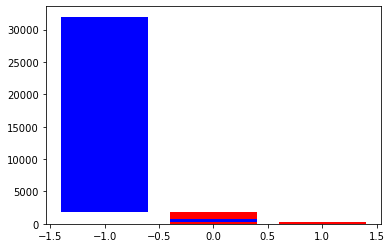

In [20]:
pre_unique = np.unique(sep_dim_pre, return_counts=True)
post_unique = np.unique(sep_dim_post, return_counts=True)
for i,aa_start in enumerate(mx_cumsum):
    if i==indx:
        print(mx[i])
        print(np.unique(s_omicron[cali_indx][cali_DRM_pre_indx,:][:,aa_start],return_counts=True))
        print(np.unique(s_omicron[cali_indx][cali_DRM_pre_indx,:][:,aa_start+1],return_counts=True))
        print(np.unique(s_omicron[cali_indx][cali_DRM_pre_indx,:][:,aa_start+2],return_counts=True))

        print(np.unique(s_omicron[cali_indx][cali_DRM_post_indx,:][:,aa_start], return_counts=True))
        print(np.unique(s_omicron[cali_indx][cali_DRM_post_indx,:][:,aa_start+1], return_counts=True))
        print(np.unique(s_omicron[cali_indx][cali_DRM_post_indx,:][:,aa_start+2], return_counts=True))


# plot bars in stack manner
print(pre_unique)
print(post_unique)
plt.bar(pre_unique[0], pre_unique[1]  , color='r')
plt.bar(post_unique[0], post_unique[1],bottom = pre_unique[1]  , color='b')

print(len(np.where(sep_dim_pre==0)[0]))
pre_bad_indx = np.where(sep_dim_pre==0)[0]
pre_indx = np.where(sep_dim_pre==1)[0]
aa_indx = mx_cumsum[indx]+3

print(np.unique(s_omicron[cali_indx][cali_DRM_pre_indx][pre_bad_indx,aa_indx]))
print(s_omicron[cali_indx][cali_DRM_pre_indx][pre_bad_indx, aa_indx])
print(np.unique(s_omicron[cali_indx][cali_DRM_pre_indx][pre_indx, aa_indx]))
print(s_omicron[cali_indx][cali_DRM_pre_indx][pre_indx, aa_indx])

plt.show()

2110
2110
30610
30610


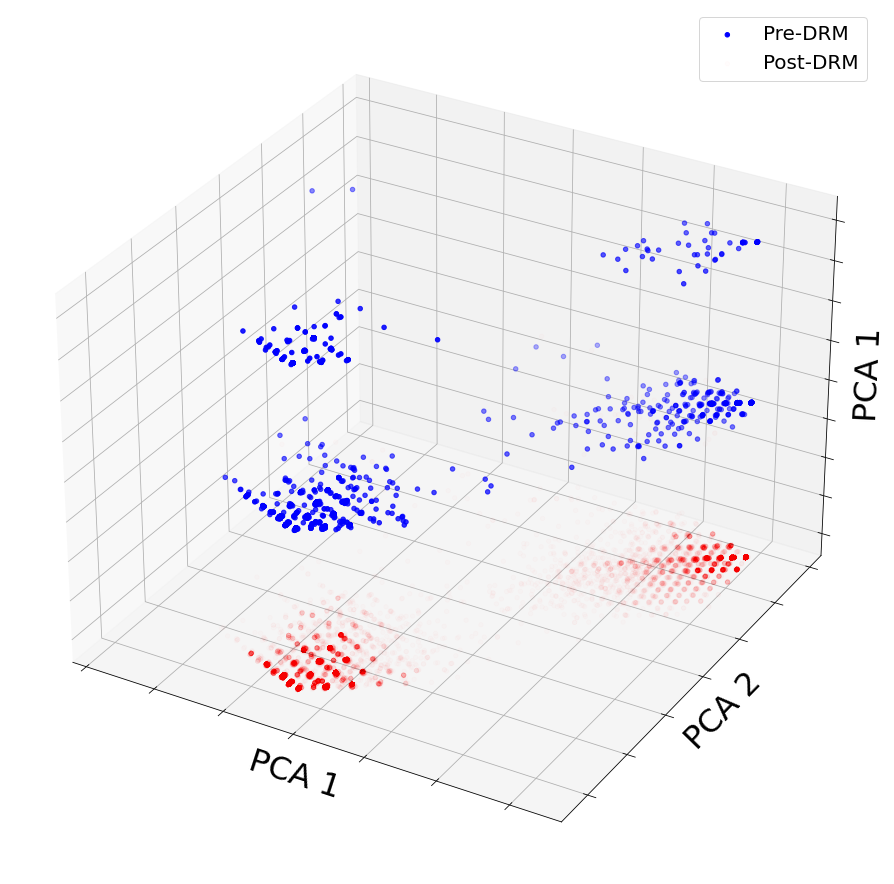

In [21]:
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')

print(len(date1_alpha))
print(len(cali_DRM_pre_indx))
print(len(date2_alpha))
print(len(cali_DRM_post_indx))
c1 = np.array(['b' for i in date1_alpha])
c2 = np.array(['r' for i in date2_alpha])

if 0:
    ax.scatter(s_pca_omicron[cali_DRM_pre_indx,0], s_pca_omicron[cali_DRM_pre_indx,1], s_pca_omicron[cali_DRM_pre_indx,i_sep],
               c=c1,label='Pre-DRM')
    ax.scatter(s_pca_omicron[cali_DRM_post_indx,0], s_pca_omicron[cali_DRM_post_indx,1], s_pca_omicron[cali_DRM_post_indx,i_sep],
               alpha=.01, c=c2,label='Post-DRM')
    ax.scatter(s_pca_full[other_indx,0], s_pca_full[other_indx,1], s_pca_full[other_indx,i_sep],
               c='k', label='Post-DRM', alpha=.01)
else:
    i_sep = 1
    ax.scatter(s_pca_omicron[cali_DRM_pre_indx,0], s_pca_omicron[cali_DRM_pre_indx,i_sep], sep_dim_pre,
               c=c1,label='Pre-DRM')
    ax.scatter(s_pca_omicron[cali_DRM_post_indx,0], s_pca_omicron[cali_DRM_post_indx,i_sep], sep_dim_post,
               alpha=.01, c=c2,label='Post-DRM')
#     ax.scatter(s_pca_full[other_indx,0], s_pca_full[other_indx,i_sep], sep_dim_full,
#                c='k', label='Post-DRM', alpha=.01)

ax.set_xlabel('PCA 1', fontsize=32)
ax.set_ylabel('PCA 2', fontsize=32)
ax.set_zlabel('PCA %d' % i_sep, fontsize=32)

ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
ax.get_zaxis().set_ticklabels([])

var_labels = [ 'Delta', 'Omicron']
legend_elements = []
# for i in range(len(var_labels)):
#     legend_elements.append(Line2D([0], [0], color=['b','r'][i], marker='o', alpha=1, label=var_labels[i]))
# ax.legend(handles=legend_elements, fontsize=20)
ax.legend(fontsize=20)
# legend = plt.legend(fontsize=28)

plt.show()

In [22]:
# Get w of the sequences from pre-DRM sequence background

s_train = s_omicron_cali[cali_DRM_pre_indx]
print('Full Omicron OneHot array: ', s_omicron.shape)
print('We will train w/b off only DRM-%d pre-mutation sequences: ' % cao_DRM[i_DRM], s_train.shape)

print('s_train: ', s_train.shape)

w_file = "%s%d%s_pre_w_Omicron_cali.npy" % (cao_aas[i_DRM][0], cao_DRM[i_DRM], cao_aas[i_DRM][1])  
b_file = "%s%d%s_pre_b_Omicron_cali.npy" % (cao_aas[i_DRM][0], cao_DRM[i_DRM], cao_aas[i_DRM][1])   
use_old = False

if os.path.exists(w_file) and use_old:                                                          
    w_ER = np.load(w_file)       
    b = np.load(b_file) 
    print('w_ER shape: ', w_ER.shape)
    no_w = False
else: 
    no_w = True

# w_ER must be the same dimensions as s-onehot
if no_w or w_ER.shape[1] != s.shape[1] or not use_old:
    print('generating w_ER for %s' % variant_name)

    # Define wight matrix with variable for each possible amino acid at each sequence position               
    w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
    h0 = np.zeros(mx.sum())    
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var))                                                                      

    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]

        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      

    # make w symmetric                                                                                   
    w_ER = (w_ER + w_ER.T)/2.                                                                            
    b = h0

    np.save(w_file, w_ER)
    np.save(b_file, b)

Full Omicron OneHot array:  (832483, 654)
We will train w/b off only DRM-371 pre-mutation sequences:  (2110, 654)
s_train:  (2110, 654)
generating w_ER for Omicron
run time: 28.35517754778266


In [23]:
from scipy.spatial import distance
# Proplerly defined Energy.. 1/24/2023

def col_H(i, i1i2, w, b, s):
    for ii, (i1,i2) in enumerate(i1i2):
        if i in range(i1,i2):
            break
    
    H_i = 0
    for j in range(len(s)):
        if j in range(i1,i2):
            continue
        H_i +=  w[i,j] * s[j] 
    H_i += b[i]
    return H_i

def E_parallel(i1i2, s, w, b, s2=None):
    s_len = len(s)
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = 20-2)(delayed(col_H)                                                   
        (i0, i1i2, w, b, s)
        for i0 in range(s_len)) 
#     print(np.array(resH).shape)
    H_array = resH
#     print(s)
#     print(max([max(wl) for wl in w]), min([min(wl) for wl in w]))
#     print(max(b), min(b))
#     print(max(H_array), min(H_array))
#     print('Calculated H for sequence')

    coshH = 0
    for i, H_i in enumerate(H_array):
            coshH += np.log(2 * np.cosh(H_i))
#         coshH += np.log(np.exp(H_i) + np.exp(-H_i))
#     print(coshH)
#     coshH = np.sum(np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]))

    
    if s2 is not None:
        sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ]))
        E_array  = np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]) 
        - np.array([sig_i * H_array[i] for i, sig_i in enumerate(s2) ])
    else:
        sum_sigH = np.sum(np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ]))
        E_array  = np.array([ np.log(2 * np.cosh(H_i)) for H_i in H_array]) 
        - np.array([sig_i * H_array[i] for i, sig_i in enumerate(s) ])
    E = coshH - sum_sigH
    
    return E, E_array
   
def energy_diff(i1i2, s1, s2, w, b, return_pos_array=False):
    e_diff = 0.
    s_len = len(s1)
    if s_len==1:
        s1 = s1.transpose()
    s_len = len(s1)
    


    if s_len != len(s2):
        print('sequences not comparable!')
        print(s_len)
        print(len(s2))
        sys.exit(24)
        
#     E1,E1_array = E_parallel(i1i2, s1, w, b)
#     E2,E2_array = E_parallel(i1i2, s2, w, b)
#     Ediff1, Ediff1_array = E_parallel(i1i2, s1, w, b, s2=s2)
#     Ediff2, Ediff2_array = E_parallel(i1i2, s2, w, b, s2=s1)
    
#     E_diff = E1 + E2 - Ediff1 - Ediff2
#     E_diff_array = E1_array + E2_array - Ediff1_array - Ediff2_array
    E_diff, E_diff_array = E_parallel(i1i2, s1, w, b, s2=s2)
    if return_pos_array:
        return E_diff, E_diff_array
    else:
        return E_diff
    
E,E_array = energy_diff(i1i2,ref_s, s_omicron_cali[1,:], w_ER, b, return_pos_array=True)
print('identity energy difference: ', E, E_array.shape)

print(E_array.shape)

nickname = 'Omicron_pre371cons_cali'
nickname = 'Omicron_cali'

s_E_rows = []
print('Consensus sequence: ', ref_s.shape)
if os.path.exists('%s_SvsCONS_energy.npy' % nickname):
    print('loading %s energy landscape' % nickname)
    s_E_row = np.load('%s_SvsCONS_energy.npy' % nickname)
else:
    s_E_row = np.zeros(len(s))
    res = Parallel(n_jobs = 30-2)(delayed(energy_diff)
            (i1i2,ref_s,s_omicron_cali[i0,:],w_ER,b)
            for i0 in range(len(s_omicron_cali)))
    s_E_row = np.array(res)
    np.save('%s_SvsCONS_energy.npy' % nickname, s_E_row)


identity energy difference:  [1321.37759995] (654, 1)
(654, 1)
Consensus sequence:  (1, 654)
loading Omicron_cali energy landscape


50259
(50259, 15)
(50259, 1)
(1, 15)
(1, 15)
(1, 15)


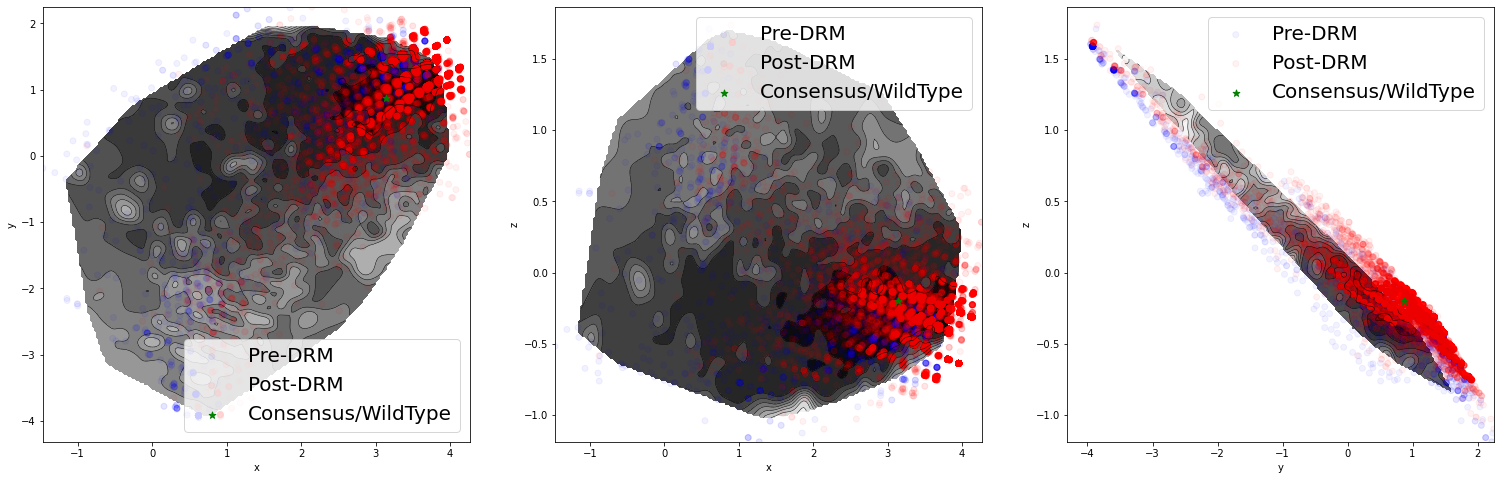

In [24]:

fig1 = plt.figure(figsize=(26,8))

ax1  = fig1.add_subplot(131)    
ax2  = fig1.add_subplot(132)    
ax3  = fig1.add_subplot(133)    




z = s_E_row.reshape(len(s_E_row),)

print(len(s_E_row))


planes = [(0,1),(0,2),(1,2)] # indices to plot x/y, x/z, and y/z planes
ax_labels = ['x', 'y' , 'z']
axes = [ax1, ax2, ax3]  # panel 1 to plot the different planes for msa 1

# s_pca is omicron cali sequences
pca_pre = s_pca[cali_DRM_pre_indx]
pca_post = s_pca[cali_DRM_post_indx]

print(s_pca.shape)
print(s_E_row.shape)
for dim in range(3):
    x = s_pca[:,planes[dim][0]]
    y = s_pca[:,planes[dim][1]]

#     print('x', x.shape)
#     print('y', y.shape)

    n_levels=10
    sigma = .001
    # Create grid values first.
    ngridx = 200
    ngridy = 200
    xi = np.linspace(min(x), max(x), ngridx)
    yi = np.linspace(min(y), max(y), ngridy)


    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    triang = tri.Triangulation(x, y)
    if len(z) == len(x):
        interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


    Xi, Yi = np.meshgrid(xi, yi)

    zi = interpolator(Xi, Yi)
    Zi = gaussian_filter(zi, sigma=2.)
    
    # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")
    axes[dim].contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
    cntr11 = axes[dim].contourf(Xi, Yi, Zi, levels=10, cmap='gray')


    # plot the sequence points for both families
#     axes[dim].scatter(s_pca[:,planes[dim][0]], s_pca[:,planes[dim][1]],alpha=.01)  
    print(ref_pca.shape)

    axes[dim].scatter(s_pca[cali_DRM_pre_indx,planes[dim][0]], s_pca[cali_DRM_pre_indx,planes[dim][1]],
               c=c1,label='Pre-DRM',alpha=.05)
    axes[dim].scatter(s_pca[cali_DRM_post_indx,planes[dim][0]], s_pca[cali_DRM_post_indx,planes[dim][1]],
                      alpha=.05, c=c2,label='Post-DRM')
#     axes[dim].scatter(s_pca_full[other_indx,planes[dim][0]], s_pca_full[other_indx,planes[dim][1]],
#                c='k', label='Post-DRM', alpha=.01)
    axes[dim].scatter(ref_pca[0,planes[dim][0]], ref_pca[0,planes[dim][1]],
           c='g',marker='*',label='Consensus/WildType',s=50)
#     axes[dim].legend(handles=legend_elements[i:i+2])
    axes[dim].legend(fontsize=20)
#     axes[dim].set_title('Energy landscape for %s Mean'% variants[msa_1])
    axes[dim].set_xlabel(ax_labels[planes[dim][0]])
    axes[dim].set_ylabel(ax_labels[planes[dim][1]])
        

x (50259,)
y (50259,)


Text(0, 0.5, 'PCA 2')

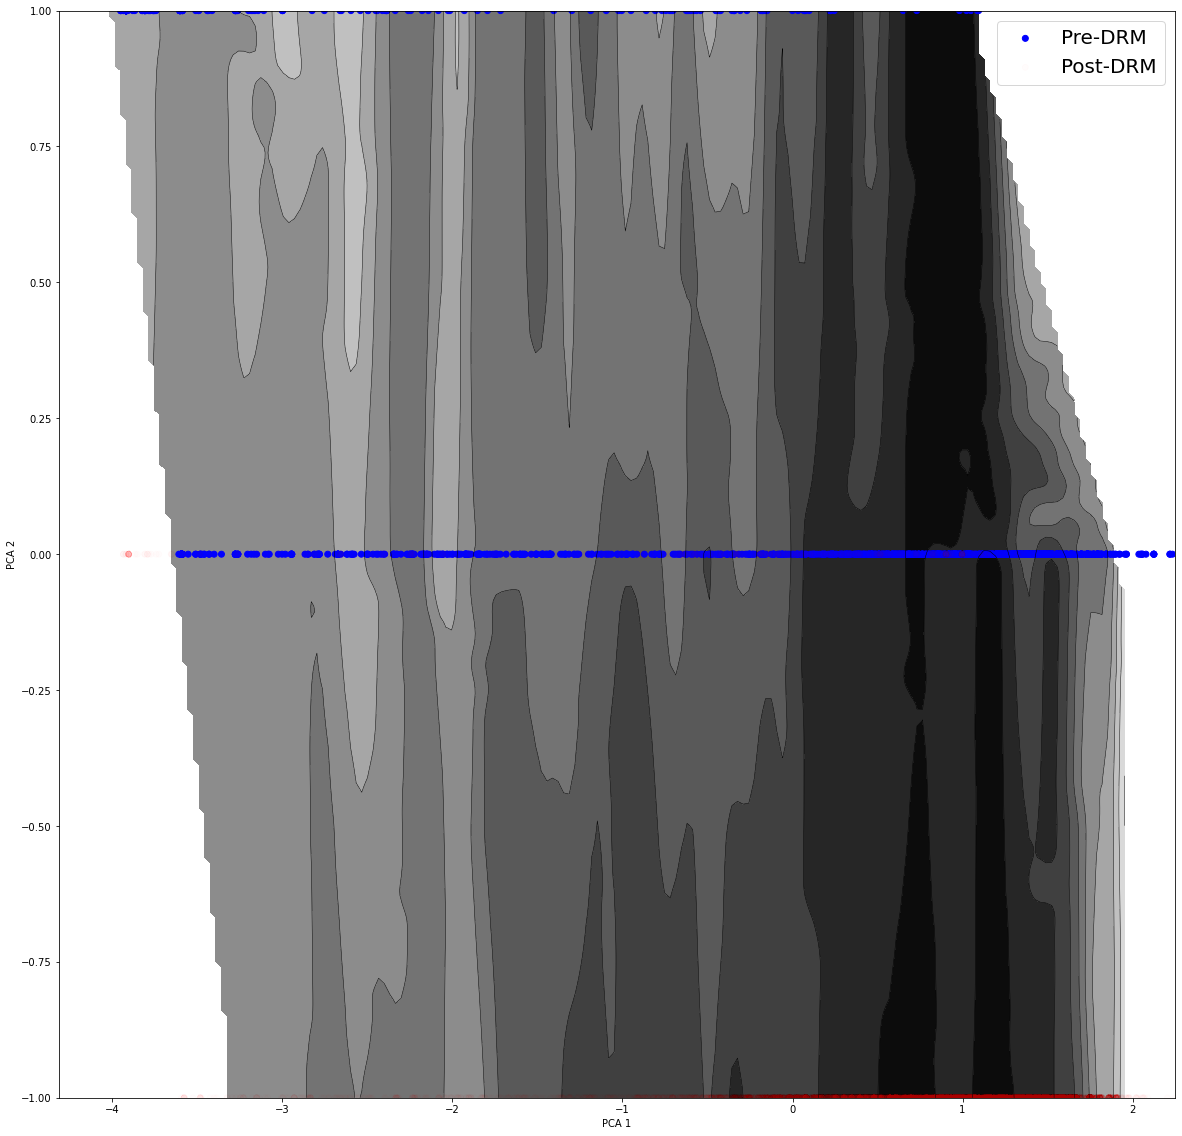

In [25]:

fig1 = plt.figure(figsize=(20,20))

ax1  = fig1.add_subplot(111)    
   
x = s_pca[:,0]
y = s_pca[:,1]
x = s_pca[:,i_sep]
y = sep_dim_cali
print('x', x.shape)
print('y', y.shape)

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)


# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)
if len(z) == len(x):
    interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


Xi, Yi = np.meshgrid(xi, yi)

zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)


ax1.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = ax1.contourf(Xi, Yi, Zi, levels=10, cmap='gray')


# plot the sequence points for both pre- and post-DRM
if 0:
    ax1.scatter(s_pca[cali_DRM_pre_indx,0], s_pca[cali_DRM_pre_indx,1],
               c=c1,label='Pre-DRM',alpha=.1)
    ax1.scatter(s_pca[cali_DRM_post_indx,0], s_pca[cali_DRM_post_indx,1], 
                      alpha=.1, c=c2,label='Post-DRM')
    #     ax1.scatter(s_pca_full[other_indx,0], s_pca_full[other_indx,1],
    #                c='k', label='Post-DRM', alpha=.01)
    ax1.scatter(ref_pca[0,0], ref_pca[0,1], c='g',marker='*',
                      label='Consensus/WildType',s=250)
else:
    ax1.scatter(s_pca[cali_DRM_pre_indx,i_sep], sep_dim_pre,
               c=c1,label='Pre-DRM')
    ax1.scatter(s_pca[cali_DRM_post_indx,i_sep], sep_dim_post,
               alpha=.01, c=c2,label='Post-DRM')
#     ax1.scatter(ref_pca[0,i_sep], np.inner(ref_s,S371L_diff), c='g',marker='*',
#                   label='Consensus/WildType',s=250)
    
ax1.legend(fontsize=20)
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
        



In [26]:
# Consensus position 371
ref_char_array = convert_number2letter(ref_seq_array)
print('\n\nref seq at 371: ', ref_char_array[indx])

ref_s = np.transpose(ref_s)
print(ref_s.shape)
# Liklihood of seeing the DRM S-->L in reference sequence given pre sequence background
E, E_array = E_parallel(i1i2, ref_s, w_ER, b) # S liklihood
(drm_i1, drm_i2) = i1i2[indx]
print(ref_s[drm_i1:drm_i2])
ref_char_array_L = ref_char_array.copy()
ref_char_array_L[indx] = 'L'
ref_seq_array_L = convert_letter2number(ref_char_array_L)

ref_s_L = onehot_encoder.transform(np.array([ref_seq_array_L]))
ref_s_L = np.transpose(ref_s_L)
E_L, E_array_L = E_parallel(i1i2, ref_s_L, w_ER, b) # L liklihood


[10  4 17  4  9 17  9  9 12  9 17 15 15 13  1 17 11  9 16 16 14 16 13  9
 12 12  0 19 16 11 15  4 16 14  5 17 19 19 12  2  8 17  4 14 15 15 17  9
  6 15 16 13  2  9  4  9 12  4  4 15 11 17 16 18  4  6 17  7  8 15 15  5
 16 11  5 16  8 14  4  2 11 12 17  9 12  4 11  2  5 17 19  4  0 15  7  3
 15 11  7  7 14  5 18  7  4  5 16 16  9  2 15  8 16 13 15  9  9  7 17 11
 11  0 11 17 17  7  8 17  1  3  4  4  1 11  2  2  0  6  8 15 18 10  3 15
  3  4 14 17 19 15 15  0 11 11  1 16  4  3 19 17 15 13 12  4  9 10  2  9
  3  5  8 13  5 11  4  8 11  9 14  3  4 17  4  8 11  7  2  5 19  4  8  7
 19 15  8  6 16 12  7  7 17 14  2  9 12 13  5  4 15  0  9  3 12  9 17  2
  9 12  7  5  7 11  7 16 14  4 13 16  9  9  0  9  6 14 15 19 16 12  5  2
 15 15 15  5 18 16  0  5  0  0  0 19 19 17  5 19  9 13 12 14 16  4  9  9
  8 19 11  3 11  5 16  7 16  2  0 17  2  1  0  9  2 12  9 15  3 16  8  1
 16  9  8 15  4 16 17  3  8  5  7 19 13 16 15 11  4 14 17 13 16  3 15 14
 15 16 17  2 14 16 11  7  8 15  9 11  0  4 14 15  8

In [27]:
print(E_array.shape)
print(E, E_array[indx])
print(E_L, E_array_L[indx])

(654, 1)
[1331.13317776] [4.38138446]
[1339.89197781] [4.38138446]


In [28]:
# Choose single mutation given sequence and w/b.
def prob_mut1(seq, i1i2, w, b, ncpu=2):
    
    # Caluculate Hi for every column of H, includeing bias.
    resH = Parallel(n_jobs = ncpu)(delayed(col_H)                                                   
        (i0, i1i2, w, b, seq)
        for i0 in range(len(seq))) 
    H_array = resH

    mut_probs = []
    prob_tot = 0.
    for i in range(len(seq)):
        H_i = H_array[i]
        mut_prob =  np.exp( H_i) / (2 * np.cosh(H_i))
        prob_tot += mut_prob
        mut_probs.append(mut_prob)
        
    return prob_tot, np.array(mut_probs)
def w_seq_walk(seq, i1i2, w_in, b_in, n_iter=1000,seed=42,ncpu=2):
    random.seed(seed)
    
    if w_in.ndim > 2:
        if w_in.ndim-1 != b_in.ndim or w_in[0].shape[1] != b_in[0].shape[0]:
            sys.exit(42)
        print('alternating walk between %d w/bs' % len(w_in))
        directions = []

    else:
        print('random walk using a cluster\'s w/b')
        w = w_in
        b = b_in
         
    seq_walk = [seq]
    n_var = len(i1i2)
    for itr in range(n_iter):
        if w_in.ndim > 2:
            indx = np.random.choice(range(len(w_in)))
            w = w_in[indx]
            b = b_in[indx]
            directions.append(indx)
        # Randomly choose seqwuence mutation (weighted with current sequence and w/b)
        prob_gp1, prob_array_gp1 = prob_mut1(seq_walk[-1], i1i2, w, b, ncpu=ncpu)
        prob_mut = prob_array_gp1/np.sum(prob_array_gp1)
#         print(prob_mut.shape)
        prob_mut = prob_mut.reshape(len(prob_mut))
#         print(prob_mut.shape)
        mut_pos_aa = np.random.choice(range(len(prob_array_gp1)), p=prob_mut)  
#         print(mut_pos_aa)
        # print([(aa,j) for aa,j in enumerate(seq_walk[-1])])
        
        # find position mut_pos_aa is in
        found = False
        for i0 in range(n_var):
            i1,i2 = i1i2[i0][0], i1i2[i0][1]
            for i, ii0 in enumerate(range(i1,i2)):
                if mut_pos_aa == ii0:
                    found = True
                    break
            if found:
                break
        # print('%d (%d, %d) in ' % (mut_pos_aa, i, ii0), i1i2[i0])
        
        # apply mutation
        temp_sequence = np.copy(seq_walk[-1])
        sig_section = np.zeros(i2-i1)
        sig_section[i] = 1.
        sig_section = sig_section.reshape(len(sig_section),1)
        temp_sequence[i1:i2] = sig_section
        # print([(aa,j) for aa,j in enumerate(temp_sequence)])
        # print('\n\n')
        seq_walk.append(temp_sequence)
    if w_in.ndim > 2:
        return seq_walk, directions
    else:
        return seq_walk

In [29]:
nwalk = 20
if 0:
    # test_res = w_seq_walk(ref_s, i1i2, w_ER, b, n_iter = 100,seed=10, ncpu = 2)
    start_time = timeit.default_timer()                                                                  
    res_pre_walk = Parallel(n_jobs = 15)(delayed(w_seq_walk)                                                   
            (ref_s, i1i2, w_ER, b, n_iter = 100,seed=i0, ncpu = 2)                                                          
            for i0 in range(nwalk)) 


    run_time = timeit.default_timer() - start_time   
    print('run time:',run_time) 
    SW = []
    for walk in res_pre_walk:
        SW.append(walk)
    np.save('%dBSW_100i_preCONS_wpre.npy' % nwalk, SW)
else:
    SW = np.load('%dBSW_100i_preCONS_wpre.npy' % nwalk)


In [30]:
SW1000_pre = np.load('100BSW_1000i_preCONS_wpre.npy')
SW1000_post = np.load('100BSW_1000i_preCONS_wpost.npy')

SW = np.array(SW)
SW1000_pre = np.array(SW1000_pre)
SW1000_post = np.array(SW1000_post)

BSW_pre_pca = []
BSW_pre_sep_dim = []
for seq_walk in SW1000_pre:
    seq_set = [seq.reshape(len(seq),) for seq in seq_walk]
    seq_set_sep_dim = [np.inner(seq.reshape((len(seq),)),S371L_diff) for seq in seq_walk]
    BSW_pre_pca.append(pca.transform(seq_set))
    BSW_pre_sep_dim.append(seq_set_sep_dim)
BSW_pre_pca = np.array(BSW_pre_pca)
print(BSW_pre_pca.shape)

# post has 655 pos not 654
# BSW_post_pca = []
# for seq_walk in SW1000_post:
#     seq_set = [seq.reshape(len(seq),) for seq in seq_walk]
#     BSW_post_pca.append(pca.transform(seq_set))
# BSW_post_pca = np.array(BSW_post_pca)
# print(BSW_post_pca.shape)

(100, 1001, 15)


0.0
[[ 3.14494147e+00  8.72718649e-01 -2.02579699e-01  1.21172237e-02
  -7.18822680e-03 -3.36406247e-01  8.20439233e-04  7.40114013e-02
   9.85712987e-02 -9.44703789e-02  1.09914541e-01 -5.95241994e-01
  -9.60033148e-01  1.93630785e-03  1.65256206e-01]]


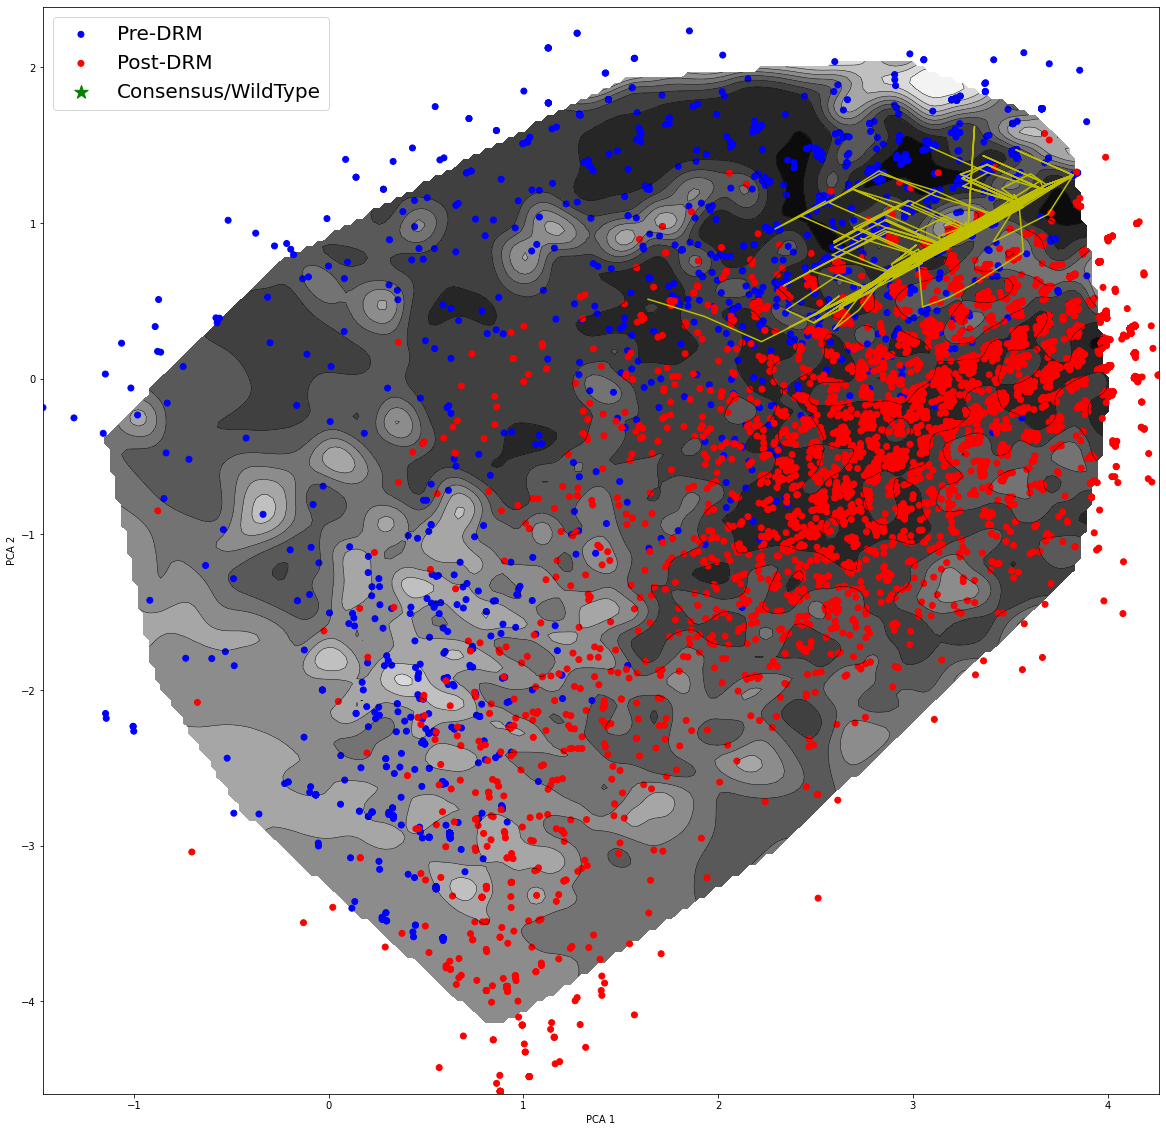

In [31]:
fig1 = plt.figure(figsize=(20,20))

ax1  = fig1.add_subplot(111)    
   
x = s_pca[:,0]
y = s_pca[:,1]

sep_ref =np.inner(ref_s.reshape((len(ref_s),)),S371L_diff)
y = s_pca[:,i_sep]+sep_dim_cali
# y = sep_dim_cali

#     print('x', x.shape)
#     print('y', y.shape)

n_levels=10
sigma = .001
# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x), max(x), ngridx)
yi = np.linspace(min(y), max(y), ngridy)


# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(x, y)
if len(z) == len(x):
    interpolator = tri.LinearTriInterpolator(triang, z[:x.shape[0]]) # going to len of x because we dont care about non Evo outliers


Xi, Yi = np.meshgrid(xi, yi)

zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)


ax1.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr11 = ax1.contourf(Xi, Yi, Zi, levels=10, cmap='gray')


# plot the sequence points for both pre- and post-DRM
ax1.scatter(s_pca[cali_DRM_pre_indx,0], s_pca[cali_DRM_pre_indx,i_sep]+sep_dim_pre,
           c=c1,label='Pre-DRM')
ax1.scatter(s_pca[cali_DRM_post_indx,0], s_pca[cali_DRM_post_indx,i_sep]+sep_dim_post, 
                   c=c2,label='Post-DRM')
# ax1.scatter(s_pca[cali_DRM_pre_indx,0],sep_dim_pre,
#            c=c1,label='Pre-DRM')
# ax1.scatter(s_pca[cali_DRM_post_indx,0], sep_dim_post, 
#                    c=c2,label='Post-DRM')



# plot the sequence points for both families
for i,seq_set in enumerate(BSW_pre_pca):
    ax1.plot(seq_set[:,0], seq_set[:,i_sep]+BSW_pre_sep_dim[i],c='y')

print(sep_ref)
print(ref_pca)
ax1.scatter(ref_pca[0,0], ref_pca[0,i_sep]+sep_ref, c='g',marker='*',
              label='Consensus/WildType',s=200)
ax1.legend(fontsize=20)
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
plt.show()

In [ ]:
nickname = 'preDRM371'

sw_E_rows = []
print('Consensus sequence: ', ref_s.shape)

for i, seq_walk in enumerate(SW1000_pre):
    if os.path.exists('%s_SW%dvsCONS_energy.npy' % (nickname,i)):
        print('loading %s energy landscape' % nickname)
        s_E_row = np.load('%s_SW%dvsCONS_energy.npy' % (nickname,i))
    else:
        seq_set = np.array([seq.reshape(len(seq),) for seq in seq_walk])
        s_E_row = np.zeros(len(seq_set))
        res = Parallel(n_jobs = 30-2)(delayed(energy_diff)
                (i1i2,ref_s,seq_set[i0,:],w_ER,b)
                for i0 in range(len(seq_set)))
        s_E_row = np.array(res)
        sw_E_rows.append(s_E_row)
        np.save('%s_SW%dvsCONS_energy.npy' % (nickname,i), s_E_row)


Consensus sequence:  (654, 1)
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy landscape
loading preDRM371 energy 

In [ ]:
print(len(sw_E_rows))
for i, s_E_row in enumerate(sw_E_rows):
    # find where 371 --> S, L
    sw_371_set = np.array([ res for res in SW1000_pre_s0[i,:,indx]])
    print(sw_371_set.shape)
    for ii, res in enumerate(sw_371_set):
        print(res)
    plt.plot(s_E_row)
plt.show()